<a href="https://colab.research.google.com/github/GaborVxxx/ml_notes/blob/main/CNN_Text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv


df = pd.read_csv('bbc_text_cls.csv')
df.head()

--2024-12-31 13:35:25--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  --.-KB/s    in 0.08s   

2024-12-31 13:35:25 (58.1 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [3]:
df['targets'] = df['labels'].astype('category').cat.codes
df.head()

,text,labels,targets
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,0
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,0
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,0
3,High fuel prices hit BA's profits\n\nBritish A...,business,0
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,0


<Axes: >

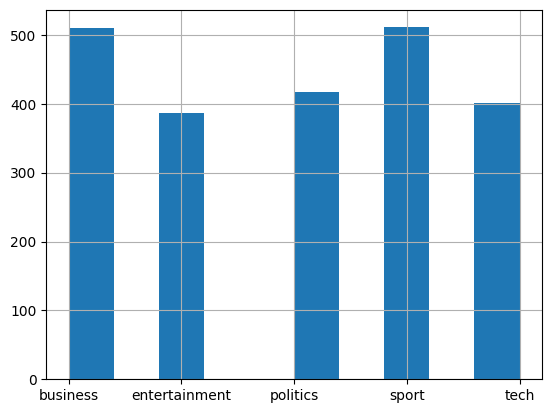

In [5]:
df['labels'].hist()

In [4]:
# number of classes
K = df['targets'].max() + 1
print(f'Number of classes: {K}')

Number of classes: 5


In [9]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [10]:
# convert sentences to sequences
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['text'])
sequence_train = tokenizer.texts_to_sequences(df_train['text'])
sequence_test = tokenizer.texts_to_sequences(df_test['text'])

In [11]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print(f'Found {V} unique tokens.')

Found 27758 unique tokens.


In [13]:
# pad sequences so that we get a N * T matrix
data_train = pad_sequences(sequence_train)

# get sequence length
T = data_train.shape[1]
print(f'Maximum sequence length: {T}')
data_test = pad_sequences(sequence_test, maxlen=T) # we make sure the sequence length is the same so we can do operation on it
print(f'Shape of data train tensor: {data_train.shape}')
print(f'Shape of data test tensor: {data_test.shape}')

Maximum sequence length: 2837
Shape of data train tensor: (1557, 2837)
Shape of data test tensor: (668, 2837)


In [14]:
# create a model

# embedding dimentions
D = 50

# Note: we want the embedding to be (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

In [15]:
# compile and fit
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=False),
    optimizer=Adam(),
    metrics=['accuracy']
)

In [16]:
r = model.fit(
    data_train, df_train['targets'].values,
    validation_data=(data_test, df_test['targets'].values),
    epochs=10,
    batch_size=32
)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - accuracy: 0.2147 - loss: 1.6049 - val_accuracy: 0.2096 - val_loss: 1.5887
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.3256 - loss: 1.4978 - val_accuracy: 0.5898 - val_loss: 0.9475
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.7030 - loss: 0.7572 - val_accuracy: 0.8458 - val_loss: 0.4492
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - accuracy: 0.9277 - loss: 0.2270 - val_accuracy: 0.8757 - val_loss: 0.3638
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.9799 - loss: 0.0845 - val_accuracy: 0.8907 - val_loss: 0.3774
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - accuracy: 0.9975 - loss: 0.0201 - val_accuracy: 0.8982 - val_loss: 0.4132
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.9998 - loss: 0.0093 - val_accuracy: 0.9072 - val_loss: 0.3734
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accu

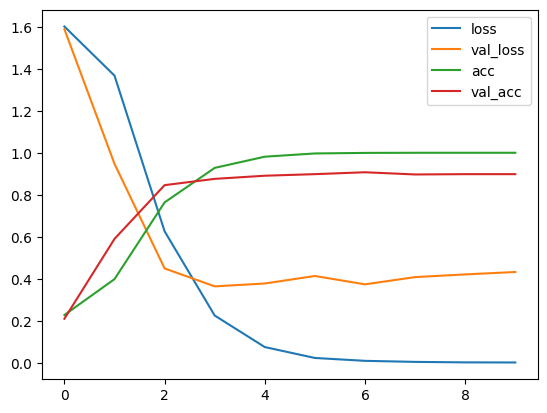

In [18]:
# plot accuracy and loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [29]:
# make a prediction
def predict_category(text):
       # Tokenize the input text
       sequence = tokenizer.texts_to_sequences([text])
       # Pad the sequence
       data = pad_sequences(sequence, maxlen=T)
       # Make a prediction
       prediction = model.predict(data).argmax() + 1 # add 1 to line up the lables properly
       print(prediction)
       print(df['labels'].astype('category').cat.categories)
       # Get the category label
       category = df['labels'].astype('category').cat.categories[prediction]
       return category



In [30]:
new_text = "this is a new document about football"
predicted_category = predict_category(new_text)
print(f"Predicted category: {predicted_category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3
Index(['business', 'entertainment', 'politics', 'sport', 'tech'], dtype='object')
Predicted category: sport


In [31]:
new_text = "this year the goverment want to incrase the taxes"
predicted_category = predict_category(new_text)
print(f"Predicted category: {predicted_category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2
Index(['business', 'entertainment', 'politics', 'sport', 'tech'], dtype='object')
Predicted category: politics
